In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import json

with open("Subtask_1_train.json") as f:
    data = json.load(f)

<hr>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peft

warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm
from peft import LoraConfig, TaskType, get_peft_model, PeftModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<hr>

In [9]:
pretrained_model = "tae898/emoberta-large"

model_l0 = AutoModelForSequenceClassification.from_pretrained(pretrained_model)

for param in model_l0.parameters():
    param.requires_grad = False

for param in model_l0.roberta.encoder.layer[-1].parameters():
    param.requires_grad = True
    
for param in model_l0.classifier.parameters():
    param.requires_grad = True

tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

<hr>

In [10]:
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

class CustomDataset(Dataset):
    def __init__(self, json_data, label2id):
        self.data = json_data
        self.emotions_map = label2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        data = deepcopy(self.data[idx])

        conversationID = data['conversation_ID']
        conversation = data['conversation']
        cause_pairs = data['emotion-cause_pairs']

        conversationID -= 1

        for utt in conversation:
            utt["utterance_ID"] -= 1

        conversation = sorted(conversation, key=lambda x: x["utterance_ID"])

        def extract(x, y):
            idx, emotion = x.split("_", maxsplit=1)
            idc, subtext = y.split("_", maxsplit=1)

            idx = int(idx) - 1
            idc = int(idc) - 1

            return {
                "cause_pair": (idx, idc),
                "cause_emotion": emotion,
                "cause_subtext": subtext,
            }

        alcause_pairs = [extract(x, y) for x, y in cause_pairs]
        conversations = []

        for x in conversation:
            row = {
                "conversation_ID": conversationID,
                "label_": self.emotions_map[x["emotion"]],
                **x,
                "cause": [c for c in alcause_pairs if c["cause_pair"][0] == x["utterance_ID"]]
            }

            conversations.append(row)

        return conversations

dataset = CustomDataset(data, model_l0.config.label2id)

In [11]:
def collate_fn(batch):

    all_texts = []
    all_speakers = []
    all_attn_target = []
    all_labels = []

    for samples in batch:
        texts = list(map(lambda x: x["text"], samples))
        causes = list(map(lambda x: x["cause"], samples))
        labels_ = list(map(lambda x: x["label_"], samples))
        speakers = list(map(lambda x: x["speaker"], samples))

        attn_target = torch.zeros(len(samples), len(samples))

        causes = sum(causes, [])
        causes = list(map(lambda x: x["cause_pair"], causes))
        causes = torch.tensor(causes)
        labels = torch.tensor(labels_)

        if len(causes) > 0:
            attn_target[causes[:, 0], causes[:, 1]] = 1

        all_texts.append(texts)
        all_speakers.append(speakers)
        all_attn_target.append(attn_target)
        all_labels.append(labels)

    return {"all_texts": all_texts,
            "all_speaker": all_speakers,
            "all_attn_target": all_attn_target, "all_labels": all_labels}

In [12]:
from torch.utils.data import random_split

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

batch_size = 8
data_loaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
    "test": DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
}

<hr>

In [7]:
labels = torch.tensor(
    [row["label_"] for rows in dataset for row in rows]) 

counts = torch.unique(labels, return_counts=True)[1]

cls_weight = counts.sum() / counts
cls_weight = (cls_weight / cls_weight.sum()).to(device)

In [8]:
cls_weight

tensor([0.0218, 0.0562, 0.0703, 0.0801, 0.1127, 0.3123, 0.3466],
       device='cuda:0')

<hr>

In [23]:
import os

if not os.path.exists("models/"):
    os.makedirs("models/")

In [44]:
def train_emotion_classifier(model, tokenizer, data_loaders, num_epochs):
    total_reports = []
    
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_l0.parameters()), lr=1e-6)
    
    model.to(device)
    
    for epoch in range(num_epochs):
        
        for phase in ["train", "test"]:
        
            if phase == "train":
                model.train()
            else:
                model.eval()
        
            reports = []

            for batch in tqdm(data_loaders[phase]):
                
                all_texts = sum(batch["all_texts"], [])
                all_speaker = sum(batch["all_speaker"], [])
                
                all_labels = torch.concatenate(batch["all_labels"])
                all_labels = all_labels.to(device)
                all_labels = all_labels.long()
                
                texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]
                
                inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
                inputs = inputs.to(device)
                
                input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
                
                output = model(input_ids=input_ids, attention_mask=attention_mask)
                    
                loss = F.cross_entropy(output.logits, all_labels, weight=cls_weight)
                
                pred = output.logits.max(dim=1)[1]
                
                accuracy = (all_labels == pred).sum() / all_labels.size(0)
                
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                report = {"phase": phase, "loss": loss.item(), "accuracy": accuracy.item()}

                reports.append(report) 
              
            dc = pd.DataFrame(reports)
            dc = dc.describe()
            dc = dc.round(3)
            total_reports.extend(reports)
            
            print(F"{epoch}. using {phase}:", dc.loc["mean"].to_json())

    return model, total_reports 

In [ ]:
model, total_reports = train_emotion_classifier(model_l0, tokenizer, data_loaders, num_epochs=3)

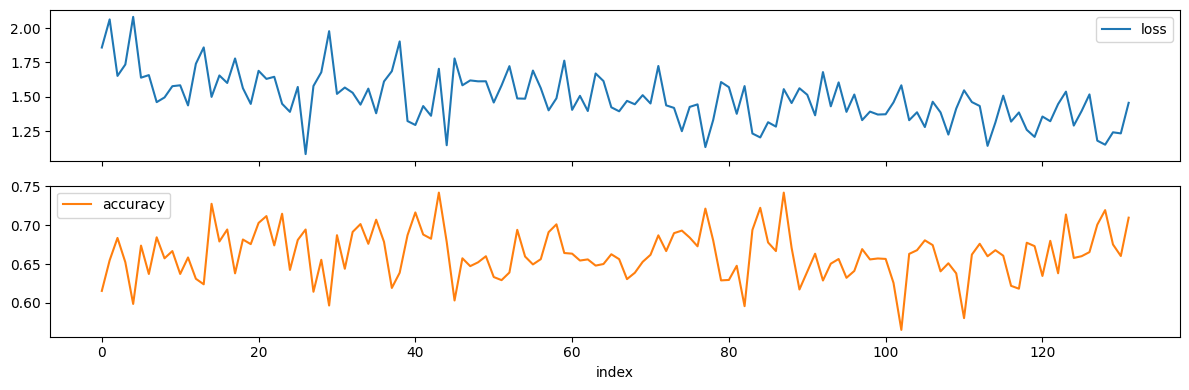

In [34]:
df = pd.DataFrame(total_reports).reset_index()
df["index"] = df["index"]

df = df.groupby("index")\
    .agg(loss=("loss", "mean"), accuracy=("accuracy", "mean"))

df.plot(subplots=True, figsize=(12, 4))
plt.tight_layout()
plt.show()

In [35]:
torch.save(model.state_dict(), 'models/model_l0_v07.pth')

<hr>

In [127]:
model_l0 = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-large")
_ = model_l0.load_state_dict(torch.load("models/model_l0_v07.pth", map_location="cpu"))
_ = model_l0.eval()

In [131]:
import torch
import torch.nn as nn

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.normalizer = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = self.normalizer(x)
        x = self.feed_forward(x)
        x = self.dropout(x)
        x, weights = self.self_attn(x, x, x, attn_mask=mask)    
        return x, weights

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, logit_dim, model_dim, n_layers, n_heads, ff_dim, max_len, dropout=0.1):
        super(TransformerEncoder, self).__init__()
  
        self.compressor = nn.Linear(embed_dim + logit_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        self.positional_encoding = self.get_positional_encoding(max_len, model_dim).permute(1, 0, 2)
        self.layers = nn.ModuleList([EncoderLayer(model_dim, n_heads, ff_dim, dropout) for _ in range(n_layers)])
        

    def get_positional_encoding(self, max_len, d_model):
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(np.log(10000.0) / d_model))
        pos_enc = torch.zeros((max_len, 1, d_model))
        pos_enc[:, 0, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 0, 1::2] = torch.cos(position * div_term)
        return pos_enc

    def forward(self, x, y, mask=None):
        
        x = torch.concatenate((x, y), dim=-1)
        x = self.compressor(x)   
        x = self.dropout(x)
        
        x = x + self.positional_encoding[:, :x.shape[1], :].to(x.device)
        
        for layer in self.layers:
            x, weights = layer(x, mask)
           
        return x, weights
    
model_l1 = TransformerEncoder(embed_dim=1024, model_dim=256, logit_dim=7, n_layers=1, n_heads=1, ff_dim=1024, max_len=40)

In [132]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_l1)

1053440

In [137]:
from torch.optim.lr_scheduler import StepLR

def train_cause_pair_extraction(embed_model, model, tokenizer, data_loaders, num_epochs=5):
    total_reports = []
    
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)    
    model.to(device)
    embed_model.eval()
    embed_model.to(device)
    
    for epoch in range(num_epochs):
        
        for phase in ["train", "test"]:
        
            if phase == "train":
                model.train()
            else:
                model.eval()
        
            reports = []

            for batch in tqdm(data_loaders[phase]):
                
                total_loss = 0.
                
                for all_texts, all_speaker, attn_targets, _ in zip(*batch.values()):
                    
                    attn_targets = attn_targets.to(device)
       
                    texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]

                    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
                    inputs = inputs.to(device)

                    input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']

                    with torch.no_grad():
                        output = embed_model(
                            input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
                        
                        embeds = output.hidden_states[-1][:, 0, :]
                        logits = F.softmax(output.logits, dim=-1)
                                    
                    embeds, logits = embeds.unsqueeze(0), logits.unsqueeze(0)
                    
                    weights = model(embeds, logits)[1].squeeze(0)
                    
                    loss = F.mse_loss(weights * 10, attn_targets * 10)
                    
                    total_loss += loss
                    
                    delta = torch.abs(attn_targets - weights)
                    recall = ((delta < 0.5) * (attn_targets == 1)).sum() / (attn_targets == 1).sum()
                    accuracy = (delta < 0.5).sum() / delta.numel()
                    
                    report = {"phase": phase, "loss": loss.item(), "accuracy": accuracy.item(), "recall": recall.item()}

                    reports.append(report) 
                    
                if phase == "train":
                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()
                                       
            dc = pd.DataFrame(reports)
            dc = dc.describe()
            dc = dc.round(3)
                        
            total_reports.extend(reports)
                        
            print(F"{epoch}.{phase}:", dc.loc["mean"].to_json())

    return model, total_reports

In [138]:
try:
    model, total_reports = train_cause_pair_extraction(model_l0, model, tokenizer, data_loaders, num_epochs=25)
except:
    pass

100%|██████████| 155/155 [01:22<00:00,  1.88it/s]


0.train: {"loss":6.127,"accuracy":0.934,"recall":0.611}


100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


0.test: {"loss":9.036,"accuracy":0.892,"recall":0.388}


100%|██████████| 155/155 [01:22<00:00,  1.88it/s]


1.train: {"loss":6.02,"accuracy":0.935,"recall":0.627}


100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


1.test: {"loss":9.188,"accuracy":0.89,"recall":0.4}


100%|██████████| 155/155 [01:22<00:00,  1.88it/s]


2.train: {"loss":5.976,"accuracy":0.936,"recall":0.634}


100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


2.test: {"loss":9.354,"accuracy":0.888,"recall":0.419}


100%|██████████| 155/155 [01:22<00:00,  1.89it/s]


3.train: {"loss":5.95,"accuracy":0.936,"recall":0.636}


100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


3.test: {"loss":9.418,"accuracy":0.887,"recall":0.41}


100%|██████████| 155/155 [01:22<00:00,  1.89it/s]


4.train: {"loss":5.913,"accuracy":0.937,"recall":0.642}


100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


4.test: {"loss":9.221,"accuracy":0.888,"recall":0.397}


100%|██████████| 155/155 [01:22<00:00,  1.88it/s]


5.train: {"loss":5.907,"accuracy":0.937,"recall":0.643}


100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


5.test: {"loss":9.343,"accuracy":0.891,"recall":0.403}


100%|██████████| 155/155 [01:22<00:00,  1.88it/s]


6.train: {"loss":5.884,"accuracy":0.937,"recall":0.649}


100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


6.test: {"loss":9.143,"accuracy":0.89,"recall":0.386}


100%|██████████| 155/155 [01:22<00:00,  1.89it/s]


7.train: {"loss":5.862,"accuracy":0.938,"recall":0.655}


100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


7.test: {"loss":9.087,"accuracy":0.89,"recall":0.379}


100%|██████████| 155/155 [01:22<00:00,  1.89it/s]


8.train: {"loss":5.84,"accuracy":0.938,"recall":0.652}


100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


8.test: {"loss":9.225,"accuracy":0.892,"recall":0.402}


 50%|████▉     | 77/155 [00:40<00:41,  1.88it/s]


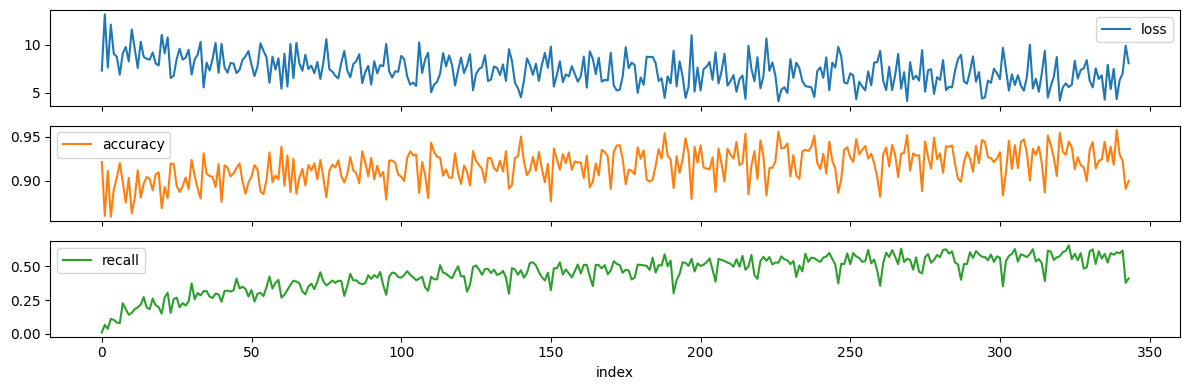

In [140]:
df = pd.DataFrame(total_reports).reset_index()
df["index"] = df["index"] // 100

df = df.groupby("index")\
    .agg(loss=("loss", "mean"), accuracy=("accuracy", "mean"), recall=("recall", "mean"))

df.plot(subplots=True, figsize=(12, 4))
plt.tight_layout()
plt.show()

In [141]:
torch.save(model.state_dict(), 'models/model_l1_v09.pth')

<hr>

In [142]:
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-large")
model_l0 = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-large")

model_l0.load_state_dict(torch.load("models/model_l0_v07.pth", map_location="cpu"))
model_l0.eval()

model_l1.load_state_dict(torch.load("models/model_l1_v09.pth", map_location="cpu"))
model_l1.eval()

test_dataset = iter(data_loaders["test"])

In [143]:
@torch.no_grad
def generate_causality_matrix(model_l0, model_l1, tokenizer, all_texts, all_speaker):
    
    model_l0.to("cpu")
    model_l1.to("cpu")
    
    texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]

    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']

    with torch.no_grad():
        output = model_l0(
            input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        embeds = output.hidden_states[-1][:, 0, :]
        logits = F.softmax(output.logits, dim=-1)

    embeds, logits = embeds.unsqueeze(0), logits.unsqueeze(0)
    
    weights = model_l1(embeds, logits)[1].squeeze(0)
    
    return torch.round(weights, decimals=2)

In [147]:
sample = next(test_dataset)

all_texts = sample["all_texts"][0]
all_speaker = sample["all_speaker"][0]

causalattn = generate_causality_matrix(model_l0, model_l1, tokenizer, all_texts, all_speaker)

print("predicted: " , (causalattn > 0.5).long(), sep="\n")
print("delta: ", sample["all_attn_target"][0].long(), sep="\n")

predicted: 
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
delta: 
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


<hr>

In [9]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

model_name = "deepset/deberta-v3-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
qa_model = AutoModelForQuestionAnswering.from_pretrained(model_name)

In [10]:
peft_config = LoraConfig(
    task_type=TaskType.QUESTION_ANS, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)

qa_model = get_peft_model(qa_model, peft_config)

qa_model.print_trainable_parameters()

trainable params: 296,450 || all params: 184,129,540 || trainable%: 0.16100078238396728


In [13]:
def qa_preparation(examples):
    
    samples = []
    prompt = "Which part of the text ’{}’ is the reason for ’ {} ’'s feeling of ’ {} ’ when ’ {} ’ is said?"

    for exp in examples:
        for ut in exp:
            for c in ut["cause"]:
                
                src = c["cause_pair"][0] 
                tgt = c["cause_pair"][1]
                
                x = {
                    "question": prompt.format(exp[tgt]["text"], ut["speaker"], c["cause_emotion"], exp[src]["text"]),
                    "context": exp[tgt]["text"],
                    'answers': {
                        'text': [c["cause_subtext"]], 
                        'answer_start': [exp[tgt]["text"].find(c["cause_subtext"])]
                    }
                }
                samples.append(x)
                
    return samples

In [14]:
train_dataset_qa = qa_preparation(train_dataset)
valid_dataset_qa = qa_preparation(valid_dataset)

In [15]:
from datasets import Dataset, DatasetDict

dataset_qa = DatasetDict({
    "train": Dataset.from_list(train_dataset_qa[:]),
    "test": Dataset.from_list(valid_dataset_qa[:]),
})

In [16]:
dataset_qa

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answers'],
        num_rows: 8398
    })
    test: Dataset({
        features: ['question', 'context', 'answers'],
        num_rows: 966
    })
})

In [17]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    
    inputs = tokenizer(questions, examples["context"], return_offsets_mapping=True, padding="max_length", truncation=True)

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"], inputs["end_positions"] = start_positions, end_positions

    return inputs

tokenized_qa = dataset_qa.map(preprocess_function, batched=True, remove_columns=dataset_qa["train"].column_names)

Map:   0%|          | 0/8398 [00:00<?, ? examples/s]

Map:   0%|          | 0/966 [00:00<?, ? examples/s]

In [16]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

2024-01-30 20:54:17.757264: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 20:54:17.794244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 20:54:17.794264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 20:54:17.795350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 20:54:17.802163: I tensorflow/core/platform/cpu_feature_guar

In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="models/qa",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
)

trainer = Trainer(
    model=qa_model, args=training_args,
    train_dataset=tokenized_qa["train"], eval_dataset=tokenized_qa["test"],
    tokenizer=tokenizer, data_collator=data_collator,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


<hr>

In [7]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

checkpoint = "models/qa/checkpoint-10500"
model_name = "deepset/deberta-v3-base-squad2"

qa_model = AutoModelForQuestionAnswering.from_pretrained(model_name)
qa_model = PeftModel.from_pretrained(qa_model, checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [18]:
inputs = tokenizer(
    dataset_qa["test"]["question"], 
    dataset_qa["test"]["context"], 
    padding=True, truncation=True, return_tensors="pt")

In [19]:
inputs["input_ids"].shape

torch.Size([966, 184])

In [20]:
with torch.no_grad():
    outputs = qa_model(**inputs)

In [21]:
answer_start_index, answer_end_index = \
    outputs.start_logits.argmax(dim=-1).tolist(), outputs.end_logits.argmax(dim=-1).tolist()

In [22]:
answers = []

for i, (start, end) in enumerate(zip(answer_start_index, answer_end_index)):
    answer = tokenizer.decode(inputs.input_ids[i, start : end + 1])
    answers.append(answer)

In [23]:
ground_truth = dataset_qa["test"]["answers"]
context = dataset_qa["test"]["context"]

report = [
    {"context": cnx, "prediction": ans, "ground_truth": d2["text"][0]}
    for cnx, ans, d2 in zip(context, answers, ground_truth)
]

In [24]:
report[0]

{'context': 'Hi ! Hi , I am Ross , you do not know me , but I am a big , big fan of yours . I mean ,',
 'prediction': 'I am a big, big fan of yours.',
 'ground_truth': 'Hi ! Hi , I am Ross , you do not know me , but I am a big , big fan of yours .'}

In [25]:
report[1]

{'context': 'Do not , do not just dismiss this so fast .',
 'prediction': 'dismiss this so fast.',
 'ground_truth': 'do not just dismiss this so fast .'}

In [26]:
report[2]

{'context': 'I am not on the list !',
 'prediction': 'I am not on the list!',
 'ground_truth': 'I am not on the list !'}

In [27]:
report[3]

{'context': 'I am not on the list !',
 'prediction': 'I am not on the list!',
 'ground_truth': 'I am not on the list !'}

In [28]:
report[4]

{'context': 'Um , see , but that is not the final draft .',
 'prediction': 'that is not the final draft.',
 'ground_truth': 'that is not the final draft .'}

In [29]:
report[5]

{'context': 'It is laminated !',
 'prediction': 'It is laminated!',
 'ground_truth': 'It is laminated !'}

<hr>